In [1]:
import pandas as pd
# Install if needed (uncomment to run)
# !pip install pandas numpy matplotlib seaborn scikit-learn statsmodels xgboost

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

# Stats / ML
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error, classification_report

# plotting defaults
%matplotlib inline
sns.set(style="whitegrid")


In [2]:
Sent_path="fear_greed_index.csv"
trade_path="historical_data.csv"

In [3]:
sent=pd.read_csv(Sent_path,low_memory=False) # low-memo --> command pandas to read the entire file at once not in chunks.
trade=pd.read_csv(trade_path,low_memory =False)
print("Sentments_columns:::--" ,sent.columns.tolist()[:20])
print("trade columns:::--",trade.columns.tolist()[:40])


Sentments_columns:::-- ['timestamp', 'value', 'classification', 'date']
trade columns:::-- ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']


In [4]:
sent.isnull().sum()   # No null values 
trade.isnull().sum()


Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

In [5]:
sent['date']=pd.to_datetime(sent['date'],errors='coerce')
sent['sent_label']=sent['classification'].str.strip()
mapping={"Extreme fear":0 , "Fear":1 , "Neutral":2 , "Greed":3 ,"Extreme Greed":4}

sent['sent_score'] =sent['sent_label'].map(mapping)
if sent['sent_score'].isna().any():
    ranks = {v: i for i, v in enumerate(sorted(sent['sent_label'].unique()))}
    sent['sent_score'] = sent['sent_score'].fillna(sent['sent_label'].map(ranks))
sent_small = sent[['date', 'sent_label', 'sent_score']].drop_duplicates()

trade['date'] = pd.to_datetime(trade['Timestamp IST'], errors='coerce').dt.normalize()
trade['Closed PnL'] = pd.to_numeric(trade['Closed PnL'], errors='coerce')
trade['Size USD'] = pd.to_numeric(trade['Size USD'], errors='coerce')
trade['Execution Price'] = pd.to_numeric(trade['Execution Price'], errors='coerce')
#-------------------------------- Droping missing values rows------------------------------>
trade =trade.dropna(subset=['date','Closed PnL'])
print("done")
sent.head(1)


done


,timestamp,value,classification,date,sent_label,sent_score
0,1517463000,30,Fear,2018-02-01,Fear,1.0


In [6]:
# Aggrigate ----------------------->
daily = trade.groupby(['date', 'Account']).agg(
    daily_PnL=('Closed PnL', 'sum'),
    trades_count=('Closed PnL', 'count'),
    win_rate=('Closed PnL', lambda x: (x > 0).mean()),
    avg_size_usd=('Size USD', 'mean'),
    avg_price=('Execution Price', 'mean')
).reset_index()

In [7]:
daily = daily.merge(sent_small, on='date', how='left')
# -----------------------------------------------------------Fill missing sentiment --possible------------------->
daily = daily.sort_values('date')
daily['sent_score'] = daily['sent_score'].ffill().bfill()


EDA (exploratory data analysis)
importing matplot and seaborn for visualization ( # Also can use plotly express)

In [8]:
import matplotlib as plt    # ITS A bad practise to use the lib again and again.
import seaborn as sns
# summary stats by sent i

summary= daily.groupby('sent_label')['daily_PnL'].agg(['mean','median','std','count']).sort_values('mean',ascending =False)
print(summary)

                       mean      median           std  count
sent_label                                                  
Fear           11332.647023  396.062720  55888.122734    157
Extreme Greed  10329.407818  108.938997  57886.533849    112
Greed           3191.793365  147.445788  24776.231695    191
Neutral         2017.749783   87.752181   5609.700498     37
Extreme Fear     133.331411    0.000000   1550.032115     33


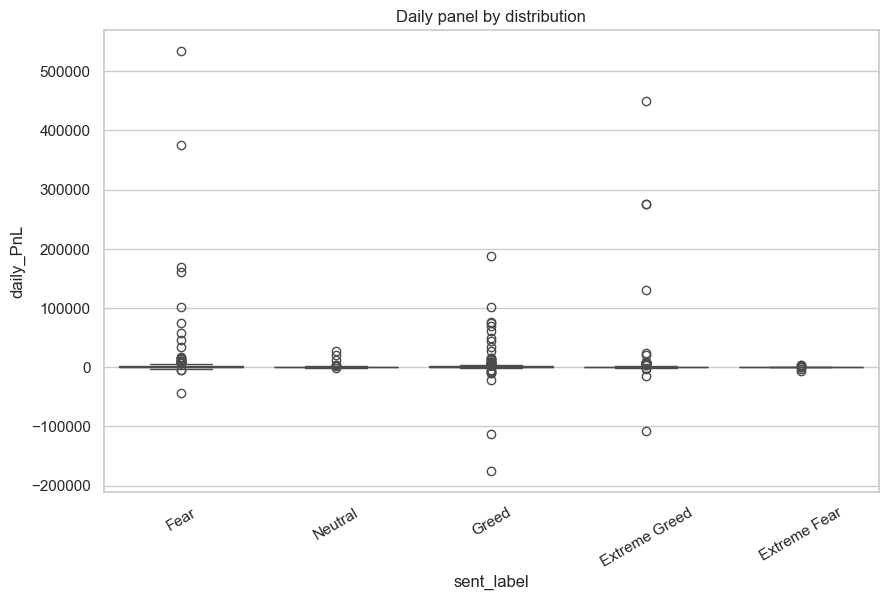

C:\Users\DELL\AppData\Local\Temp\ipykernel_12280\3681261638.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='sent_label', y='trades_count', data=daily, ci=None)


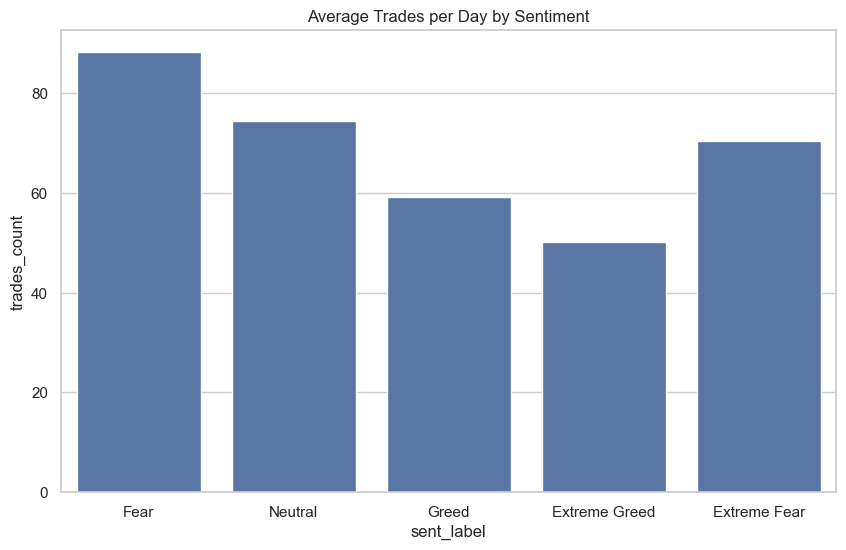

In [9]:
import matplotlib.pyplot as plt # <--------------------------- x
import seaborn as sns #  <------------------------------       x
# box plot by matplot 
plt.figure(figsize=(10,6))
sns.boxplot(x='sent_label',y='daily_PnL',data=daily)
plt.xticks(rotation=30)
plt.title("Daily panel by distribution")
plt.show()
plt.figure(figsize=(10,6))
sns.barplot(x='sent_label', y='trades_count', data=daily, ci=None)
plt.title("Average Trades per Day by Sentiment")
plt.show()

In [10]:
from scipy import stats

groups = [g['daily_PnL'].dropna().values for _, g in daily.groupby('sent_label')]

# If more than 2 sentiment groups, use ANOVA
fstat, pval = stats.f_oneway(*groups)
print(f"ANOVA test: F={fstat:.4f}, p-value={pval:.4f}")


ANOVA test: F=1.2653, p-value=0.2825


In [11]:
corr = daily[['sent_score', 'daily_PnL']].corr().iloc[0,1]
print(f"Correlation between Sentiment Score and Daily PnL: {corr:.4f}")


Correlation between Sentiment Score and Daily PnL: -0.0105


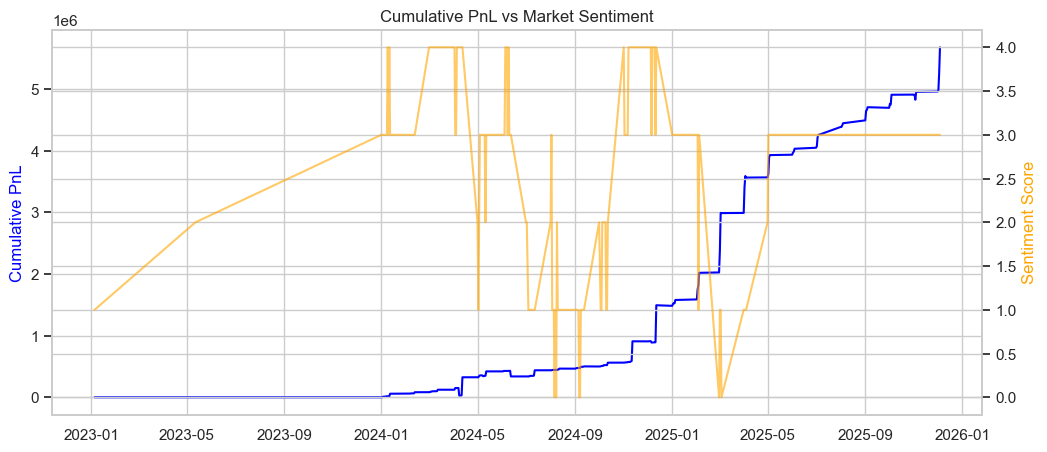

In [12]:
# Cumulative PnL vs Sentiment
platform_pnl = daily.groupby('date')['daily_PnL'].sum().reset_index()
platform_pnl = platform_pnl.merge(daily[['date', 'sent_score']].drop_duplicates(), on='date', how='left')

fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(platform_pnl['date'], platform_pnl['daily_PnL'].cumsum(), label='Cumulative PnL', color='blue')
ax1.set_ylabel('Cumulative PnL', color='blue')
ax2 = ax1.twinx()
ax2.plot(platform_pnl['date'], platform_pnl['sent_score'], label='Sentiment Score', color='orange', alpha=0.6)
ax2.set_ylabel('Sentiment Score', color='orange')

plt.title("Cumulative PnL vs Market Sentiment")
plt.show()


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

daily['profitable'] = (daily['daily_PnL'] > 0).astype(int)
features = ['trades_count', 'avg_size_usd', 'avg_price', 'sent_score']
X = daily[features].fillna(0)
y = daily['profitable']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, probs))
print(classification_report(y_test, preds))


ROC-AUC: 0.6096381429221667
              precision    recall  f1-score   support

           0       0.56      0.29      0.38       104
           1       0.66      0.86      0.75       169

    accuracy                           0.64       273
   macro avg       0.61      0.57      0.56       273
weighted avg       0.62      0.64      0.61       273



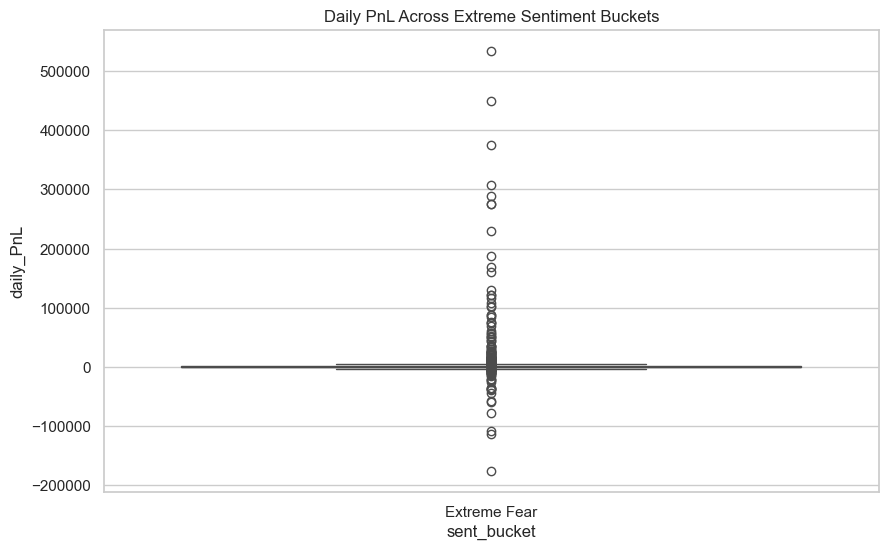

In [14]:
# Define extreme sentiment categories
def sentiment_category(score):
    if score <= 20:
        return 'Extreme Fear'
    elif score >= 80:
        return 'Extreme Greed'
    else:
        return 'Neutral'

daily['sent_bucket'] = daily['sent_score'].apply(sentiment_category)

# Boxplot for extreme sentiment
plt.figure(figsize=(10,6))
sns.boxplot(x='sent_bucket', y='daily_PnL', data=daily)
plt.title('Daily PnL Across Extreme Sentiment Buckets')
plt.show()


In [15]:
    # Shift sentiment score by 1 day
    daily['sent_score_lag1'] = daily['sent_score'].shift(1)
    
    # Drop NaNs created by the shift
    lagged_data = daily.dropna(subset=['sent_score_lag1'])
    
    # Correlation with lag
    corr_lag1 = lagged_data['sent_score_lag1'].corr(lagged_data['daily_PnL'])
    print(f"Lag 1-day Correlation: {corr_lag1:.4f}")


Lag 1-day Correlation: -0.0132


In [16]:
# Shift sentiment score by 1 day
daily['sent_score_lag1'] = daily['sent_score'].shift(1)

# Drop NaNs created by the shift
lagged_data = daily.dropna(subset=['sent_score_lag1'])

# Correlation with lag
corr_lag1 = lagged_data['sent_score_lag1'].corr(lagged_data['daily_PnL'])
print(f"Lag 1-day Correlation: {corr_lag1:.4f}")


# Create bullish/bearish labels
daily['market_trend'] = (daily['daily_PnL'] > 0).map({True: 'Bullish', False: 'Bearish'})

# Check average PnL by sentiment *within* each market condition
daily.groupby(['market_trend', 'sent_label'])['daily_PnL'].mean()


Lag 1-day Correlation: -0.0132


market_trend  sent_label   
Bearish       Extreme Fear      -487.983017
              Extreme Greed    -2688.461655
              Fear             -1051.130874
              Greed            -4996.637056
              Neutral           -177.648542
Bullish       Extreme Fear       976.543848
              Extreme Greed    20092.809922
              Fear             18587.789630
              Greed             8036.614697
              Neutral           3690.434222
Name: daily_PnL, dtype: float64

In [17]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Make sure 'sent_label' is categorical
daily['sent_label'] = daily['sent_label'].astype('category')

# Example Factor 2: Trade size category
daily['size_category'] = pd.cut(daily['avg_size_usd'], 
                                bins=[0, 1000, 5000, daily['avg_size_usd'].max()],
                                labels=['Small', 'Medium', 'Large'])

daily['size_category'] = daily['size_category'].astype('category')

# Drop missing
anova_df = daily.dropna(subset=['daily_PnL', 'sent_label', 'size_category'])

# Two-way ANOVA model
model = ols('daily_PnL ~ C(sent_label) + C(size_category) + C(sent_label):C(size_category)', 
            data=anova_df).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                                      sum_sq     df         F    PR(>F)
C(sent_label)                   8.726756e+09    4.0  1.184733  0.316542
C(size_category)                1.021180e+10    2.0  2.772681  0.063429
C(sent_label):C(size_category)  2.029685e+10    8.0  1.377737  0.203472
Residual                        9.465323e+11  514.0       NaN       NaN


In [22]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# --------------------
# 1. Two-way ANOVA (Sentiment × Market Trend)
# --------------------
model = ols('daily_PnL ~ C(sent_label) + C(market_trend) + C(sent_label):C(market_trend)', data=daily).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("=== Two-way ANOVA: Sentiment × Market Trend ===")
print(anova_table)

# Tukey's HSD for significant factors
if anova_table['PR(>F)']['C(sent_label)'] < 0.05:
    print("\nTukey HSD for Sentiment (overall):")
    tukey_sentiment = pairwise_tukeyhsd(endog=df['PnL'], groups=daily['sent_label'], alpha=0.05)
    print(tukey_sentiment)

if anova_table['PR(>F)']['C(market_trend)'] < 0.05:
    print("\nTukey HSD for Market Trend (overall):")
    tukey_market = pairwise_tukeyhsd(endog=daily['daily_PnL'], groups=daily['market_trend'], alpha=0.05)
    print(tukey_market)

# --------------------
# 2. One-way ANOVA (Bullish only)
# --------------------
bullish_df = daily[daily['market_trend'] == 'Bullish']
model_bullish = ols('daily_PnL ~ C(sent_label)', data=bullish_df).fit()
anova_bullish = sm.stats.anova_lm(model_bullish, typ=2)
print("\n=== One-way ANOVA (Bullish only) ===")
print(anova_bullish)

if anova_bullish['PR(>F)']['C(sent_label)'] < 0.05:
    print("\nTukey HSD for Sentiment (Bullish only):")
    tukey_bullish = pairwise_tukeyhsd(endog=bullish_df['PnL'], groups=bullish_df['sent_label'], alpha=0.05)
    print(tukey_bullish)

# --------------------
# 3. One-way ANOVA (Bearish only)
# --------------------
bearish_df = daily[daily['market_trend'] == 'Bearish']
model_bearish = ols('daily_PnL ~ C(sent_label)', data=bearish_df).fit()
anova_bearish = sm.stats.anova_lm(model_bearish, typ=2)
print("\n=== One-way ANOVA (Bearish only) ===")
print(anova_bearish)

if anova_bearish['PR(>F)']['C(sent_label)'] < 0.05:
    print("\nTukey HSD for Sentiment (Bearish only):")
    tukey_bearish = pairwise_tukeyhsd(endog=bearish_df['PnL'], groups=bearish_df['sent_label'], alpha=0.05)
    print(tukey_bearish)


=== Two-way ANOVA: Sentiment × Market Trend ===
                                     sum_sq     df          F    PR(>F)
C(sent_label)                  8.664868e+09    4.0   1.197085  0.311109
C(market_trend)                3.090654e+10    1.0  17.079432  0.000042
C(sent_label):C(market_trend)  5.164759e+09    4.0   0.713531  0.582927
Residual                       9.409798e+11  520.0        NaN       NaN

Tukey HSD for Market Trend (overall):
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
 group1  group2  meandiff  p-adj   lower      upper    reject
-------------------------------------------------------------
Bearish Bullish 15326.0892   0.0 10285.2403 20366.9381   True
-------------------------------------------------------------

=== One-way ANOVA (Bullish only) ===
                     sum_sq     df         F    PR(>F)
C(sent_label)  1.310381e+10    4.0  1.159147  0.328871
Residual       8.845929e+11  313.0       NaN       NaN

=== One-way ANOVA (Bearish only) ===
  